In [11]:
import altair as alt

import pandas as pd

import itertools

import numpy

import sklearn.manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from IPython.utils import io

import glob

In [2]:
import os
os.chdir('../../')

In [3]:
# define samples in each age cohort
ped_sera = [2367, 3944, 2462, 2389, 2323, 2388, 2463, 3973, 4299, 4584]
teen_sera = [2343, 2350, 2365, 2380, 2382, 3866, 3856, 3857, 3862, 3895]
adult_sera = ['33C', '34C', '197C', '199C', '215C', '210C', '74C', '68C', '150C', '18C']

# get list of lists for samples divided by age group
serum_lists = [ped_sera, teen_sera, adult_sera]
age_cohorts = ['0-5', '15-18', '40-45']

# adjust this if we want more stringent filtering
min_times_seen = 5

df_list = []

i = 0 # for looping across age cohort definitions

for list in serum_lists:
    for serum in list:
        # reading in values from averaged libA and libB models
        avg_df = pd.read_csv(f'results/antibody_escape/{serum}_icXX_avg.csv'
                            ).query(f"`times_seen` >= {min_times_seen}")
        
        avg_df = avg_df[['site', 'wildtype', 'mutant', 'log2 fold change IC90 mean']]

        avg_df = avg_df.rename(columns={'log2 fold change IC90 mean': 'ic90_mean'})
        
        serum = str(serum) # ped / teen sera automatically read as ints
        avg_df['serum'] = serum
        avg_df['age_cohort'] = age_cohorts[i]

        # also get summed and mean site scores to check AA-level vs site-level metrics
        avg_df['sitewise_ic90_sum'] = avg_df['ic90_mean'].groupby(avg_df['site']).transform('sum')
        avg_df['sitewise_ic90_mean'] = avg_df['ic90_mean'].groupby(avg_df['site']).transform('mean')

        df_list.append(avg_df)

    i+=1

# concat to final df
escape_df = pd.concat(df_list).reset_index(drop=True)

escape_df.head()

,site,wildtype,mutant,ic90_mean,serum,age_cohort,sitewise_ic90_sum,sitewise_ic90_mean
0,-2,D,Y,-0.1270,2367,0-5,-0.1270,-0.127000
1,1,Q,R,-0.1413,2367,0-5,-0.1413,-0.141300
2,2,K,N,0.0437,2367,0-5,0.0437,0.043700
3,3,I,A,0.0551,2367,0-5,-0.7658,-0.042544
4,3,I,D,0.0938,2367,0-5,-0.7658,-0.042544


In [27]:
sitewise_escape = escape_df[['serum', 'site', 'sitewise_ic90_sum']].drop_duplicates()

sitewise_mat = (
    sitewise_escape.pivot_table(index='site',
                                columns='serum',
                                values='sitewise_ic90_sum',
                                fill_value=0)
)

sitewise_mat_norm = sitewise_mat.copy()
for column in sitewise_mat_norm.columns:
    serum_sum = sum(abs(sitewise_mat[column]))
    sitewise_mat_norm[column] = sitewise_mat[column] / serum_sum

sitewise_mat_norm = sitewise_mat_norm.T
sitewise_mat_norm

site,-2,1,2,3,4,5,6,7,8,9,...,516,517,521,524,525,526,529,537,538,540
serum,,,,,,,,,,,,,,,,,,,,,
150C,-0.000327,0.000026,0.000000,-0.004479,-0.002203,0.000434,0.001264,0.000991,-0.002964,-0.005572,...,0.000357,-0.000545,-0.000655,0.000000,-0.000119,0.000302,0.001259,-0.000528,-0.001152,-5.110737e-04
18C,0.000443,0.000447,0.000000,0.001958,0.003401,0.004085,-0.002057,-0.003343,-0.004465,-0.005762,...,0.000012,-0.000416,-0.000494,0.000000,-0.000373,0.000281,-0.001189,-0.000511,-0.000781,-4.589675e-04
197C,0.000054,0.000000,0.000000,-0.001532,-0.001544,0.000596,-0.000530,-0.000666,-0.001204,-0.002602,...,-0.000806,-0.000470,-0.000843,-0.000954,0.000906,-0.000033,-0.001460,0.000664,0.000452,-1.434996e-03
199C,0.002293,0.000000,0.000000,0.000011,-0.002124,-0.003390,0.002433,0.001058,-0.003263,-0.001837,...,-0.000189,0.000071,-0.000210,0.000540,0.000185,0.000039,-0.001381,-0.000499,-0.000534,-1.921727e-03
210C,-0.000098,-0.000153,0.000000,-0.007956,-0.003588,-0.003017,-0.000168,-0.003845,-0.003897,-0.001612,...,0.000490,-0.000317,-0.000156,0.000000,-0.000117,0.000238,-0.000449,-0.000382,-0.001952,-1.316508e-03
215C,0.000483,0.000000,0.000000,-0.003463,-0.003591,-0.000241,-0.001347,-0.002914,0.002791,0.001239,...,-0.000774,-0.000006,-0.000203,-0.000456,0.000391,0.000031,-0.002702,-0.000712,-0.001261,-5.694722e-04
2323,0.001835,0.000552,0.000220,-0.004929,-0.001773,-0.003044,-0.005081,0.000253,-0.004335,0.001432,...,-0.000078,0.000211,-0.000591,0.000107,0.000557,0.000375,0.001097,-0.001748,-0.000194,-2.602348e-03
2343,0.001654,0.000000,0.000088,0.000278,-0.002428,-0.001459,-0.004609,-0.002122,0.002926,-0.001292,...,0.000328,0.000323,-0.000043,-0.000596,0.000131,-0.001084,-0.001383,0.000049,0.000016,-3.107078e-04
2350,0.000028,0.000000,-0.000377,-0.002123,-0.000755,-0.001811,0.000930,-0.005062,0.000564,-0.003000,...,0.000220,-0.000017,0.001380,-0.000524,0.000739,0.000202,-0.000230,-0.000554,0.000096,-1.814130e-03


In [54]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np

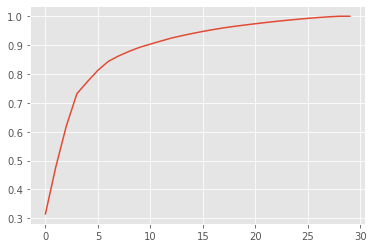

In [55]:
pca = PCA()
site_sum_pca = pca.fit_transform(sitewise_mat_norm)
pca.explained_variance_ratio_

plt.plot(np.cumsum(pca.explained_variance_ratio_))
# site_sum_pca = pd.DataFrame(site_sum_pca)

# sera = sitewise_mat_norm.index.to_list()
# site_sum_pca['serum'] = sera

# # get one line per serum from full escape df, for age cohort mapping
# age_cohort_df = escape_df.groupby('serum', group_keys=False).apply(lambda df: df.sample(1))

# # add age cohort column
# site_sum_pca = site_sum_pca.merge(age_cohort_df[['serum', 'age_cohort']],
#                         how='left',
#                         on='serum', 
#                        )

# site_sum_pca

In [38]:
# calculate aspect ratio for plotting
x_range = site_sum_pca['x'].max() - site_sum_pca['x'].min()
y_range = site_sum_pca['y'].max() - site_sum_pca['y'].min()
aspect_ratio = x_range / y_range

# visualize with altair
pca_plot = (
    alt.Chart(site_sum_pca)
    .encode(
        x=alt.X("x",
                scale=alt.Scale(padding=5),
               ),
        y=alt.Y("y",
                scale=alt.Scale(padding=5),
               ),
        tooltip=['serum', 'age_cohort'],
        color=alt.Color('age_cohort:N'
                       ).scale(scheme='set2'),
        detail='serum',
    )
    .mark_circle(size=100, opacity=0.7)
    .properties(width=300, height=300 / aspect_ratio)
    .configure_axis(
        grid=False,
        title=None,
        labelFontSize=12
    )
    .configure_legend(
        titleFontSize=15,
        labelFontSize=13
    )
)

pca_plot

alt.Chart(...)

In [59]:
# define samples in each age cohort
ped_sera = [2367, 3944, 2462, 2389, 2323, 2388, 2463, 3973, 4299, 4584]
teen_sera = [2343, 2350, 2365, 2380, 2382, 3866, 3856, 3857, 3862, 3895]
adult_sera = ['33C', '34C', '197C', '199C', '215C', '210C', '74C', '68C', '150C', '18C']

# get list of lists for samples divided by age group
serum_lists = [ped_sera, teen_sera, adult_sera]
age_cohorts = ['0-5', '15-18', '40-45']

# adjust this if we want more stringent filtering
min_times_seen = 5

df_list = []

i = 0 # for looping across age cohort definitions

for list in serum_lists:
    for serum in list:
        # reading in values from just libB models
        beta_df = pd.read_csv(f'results/antibody_escape/{serum}_rep.csv'
                                 ).query(f"`times_seen` >= {min_times_seen}"
                                        ).query("`library` == 'libA'")
        ic90_df = pd.read_csv(f'results/antibody_escape/{serum}_icXX_rep.csv'
                                 ).query(f"`times_seen` >= {min_times_seen}"
                                        ).query("`library` == 'libA'")

        # get both ic90 and beta in same df
        full_df = beta_df.merge(ic90_df,
                                    how='left',
                                    on=['site', 'wildtype', 'mutant']
                                   )[['site', 'wildtype', 'mutant', 'escape', 
                                      'log2 fold change IC90']]

        full_df = full_df.rename(columns={'log2 fold change IC90': 'ic90',
                                          'escape': 'beta'
                                         })
        serum = str(serum) # ped / teen sera automatically read as ints
        full_df['serum'] = serum
        full_df['age_cohort'] = age_cohorts[i]

        # also get summed site scores to check AA-level vs site-level metrics
        full_df['sitewise_beta'] = full_df['beta'].groupby(full_df['site']).transform('sum')
        full_df['sitewise_ic90'] = full_df['ic90'].groupby(full_df['site']).transform('sum')

        df_list.append(full_df)

    i+=1

# concat to final df
escape_df = pd.concat(df_list).reset_index(drop=True)

escape_df.head()

,site,wildtype,mutant,beta,ic90,serum,age_cohort,sitewise_beta,sitewise_ic90
0,-2,D,Y,0.4745,0.6846,2367,0-5,0.4745,0.6846
1,1,Q,H,-0.0830,-0.1198,2367,0-5,-0.2718,-0.3922
2,1,Q,R,-0.1888,-0.2724,2367,0-5,-0.2718,-0.3922
3,3,I,A,0.1373,0.1981,2367,0-5,-0.0945,-0.1363
4,3,I,D,0.1773,0.2558,2367,0-5,-0.0945,-0.1363


In [60]:
escape_df.to_csv('scratch_notebooks/230605_mds-analysis/escape_df_libA.csv')